# Homework Assignment #2

*due Tuesday, February 15, 2019 by 11:59pm*

This homework is worth **10 points** [100%], there are no bonus points questions, however, up to 1 bonus point may be given for **clearly written code** (provided that the code is correct).

### n.b.
All deliverables are required to be typed and all graphs and statistical output generated in Jupyter Notebook using Python and associated packages. Deliverables with *any* handwritten elements will not be accepted and will receive a grade of zero. 

Similarly to `hw1` copy the whole directory `hw2` to your own private repository (**use the same one as for `hw1`**).

In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
from scipy.linalg import eigh
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Linear Regression - the closed form solution [total of 15%]

***DO NOT USE ANY REGRESSION FUNCTIONS OR REGRESSION PACKAGES FOR THIS PROBLEM***

### Data for Part 1:
Suggested steps:
* Read the [housing data](https://s3-us-west-1.amazonaws.com/usfca-cs686-ml/hw1/housing.csv) used in `hw1`
* Use the column "`GrLivArea`" as your independent variable and "`SalePrice`" as your dependent variable. (You can safely disregard the rest of the dataset)

In [3]:
# Read the data here (not graded)
data_path = os.path.join(os.path.dirname(os.getcwd()), "hw1", "data", "housing.csv")
df = pd.read_csv(data_path)[["GrLivArea", "SalePrice"]]

#### Find estimates for $\beta_0$ and $\beta_1$

We know that the formula for $\beta_0$ and $\beta_1$ are:
$$\beta_0 = \bar{Y} - \beta_1\bar{X}$$
<br>
$$\beta_1 = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{\sum_{i=1}^{n}(X_i - \bar{X})^2} = \frac{s_{xy}}{s_x^2}$$

In [4]:
X_minus_mean = (df - df.mean())["GrLivArea"]
Y_minus_mean = (df - df.mean())["SalePrice"]
covariance_xy = np.sum(X_minus_mean * Y_minus_mean)
variance_x = np.sum(np.square((df - df.mean())["GrLivArea"]))
beta1 = covariance_xy / variance_x
beta0 = df.mean()["SalePrice"] - beta1 * df.mean()["GrLivArea"]
beta0, beta1

(18569.02585648728, 107.13035896582517)

#### Find $R^2$

$$R^2 = \frac{SSR}{SSTO} = 1 - \frac{SSE}{SSTO}$$
<br>
<center>where </center>
$$SSTO \equiv \sum_{i=1}^{n}(Y_i - \bar{Y})^2$$
$$SSE \equiv \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2$$
$$SSR \equiv \sum_{i=1}^{n}(\hat{Y_i} - \bar{Y})^2$$

In [5]:
df["PredictionPrice"] = beta0 + df["GrLivArea"] * beta1

In [6]:
SSTO = np.sum(np.square(df["SalePrice"] - df.mean()["SalePrice"]))
SSE = np.sum(np.square(df["SalePrice"] - df["PredictionPrice"]))
SSR = np.sum(np.square(df["PredictionPrice"] - df.mean()["SalePrice"]))

In [7]:
(SSR/SSTO, 1 - SSE/SSTO)

(0.5021486502718039, 0.5021486502718042)

$$R^2 = 0.5021$$

## Part 2: Linear Regression - the iterative solution [total of 35%]

***YOU ARE ASKED TO CODE THE FOLLOWING EXERCISE FROM SCRATCH. DO NOT USE ANY PACKAGES FOR AUTOMATIC DIFFERENTIATION FOR THIS PROBLEM.***

### <span style="color: #DA122C;">**YOUR SOLUTION MUST WORK FOR ANY GIVEN NUMBER OF INDEPENDENT VARIABLES**</span>

HINT: To make your implementation stand out, try implementing this question following a functional programming paradigm (i.e. define functions)

In [8]:
## YOU WILL NEED THESE PARAMETERS ##
# DO NOT CHANGE ANYTHING IN THIS CELL
init_eta = 1e-4 # eta, gamma, learning rate or whatever you want to call it ¯\_(ツ)_/¯
num_iters = 100 # number of iterations
n = 1000

In [12]:
# DO NOT CHANGE ANYTHING IN THIS CELL
np.random.seed(42)
r = np.eye(int(np.sqrt(n)/3)-1)
r += np.random.normal(0, 0.1, size=(r.shape[0],)*2)
lams, A = eigh(r)
c = np.dot(A, np.diag(np.sqrt(lams)))
X = np.dot(c, norm.rvs(size=(r.shape[0], n))).transpose()
Y = np.random.randn(r.shape[0]+1).dot(np.concatenate((X, np.ones((n,1))), axis=1).transpose()) + np.random.normal(0, 0.5, n)
del r, lams, A, c


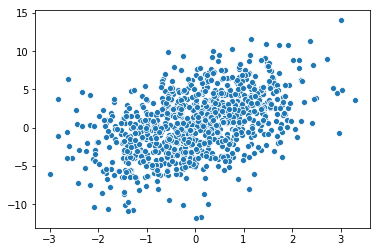

In [39]:
sb.scatterplot(X[:,0], Y)

Using MSE for the loss function, where
$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y} - Y_i)^2$$
#### Gradient Descent for Linear regression
$$Cost function = J(\Theta_0, \Theta_1) = \frac{MSE}{2} = \frac{1}{2m}\sum_{i=1}^{m}(\hat{Y} - Y_i)^2$$
$$J(\Theta_0, \Theta_1) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\Theta}(X_i) - Y_i)^2$$
$$h_\Theta(X_i) = \Theta_0 + \Theta_1 X_i$$



$$\frac{\partial J_\Theta}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m}(h_\Theta (X_i) - Y_i) \frac{\partial}{\partial \Theta_j} ((\Theta_0 + \Theta_1 X_i) + Y_i)$$

$$\Theta_j := \Theta_j - \eta \frac{\partial}{\partial \Theta_j} J(\Theta_0, \Theta_1)$$

$$\Theta_0 := \Theta_0 - \eta \frac{1}{m} \sum_{i=1}^{m}(h_\Theta (X_i) - Y_i)$$
$$\Theta_1 := \Theta_1 - \eta \frac{1}{m} \sum_{i=1}^{m}(h_\Theta (X_i) - Y_i)X_i$$

In [41]:
# Start your solution here with data X and labels Y
def linear_regression(X, Y, init_eta, num_iters, n):
    # Choose initial arbitrary values for theta_0 and theta_1
    #theta0 = np.mean(Y)
    #theta1 = np.random.uniform(np.min(X), np.max(X))
    
    theta0 = 0
    theta1 = 0
    
    for i in range(num_iters):
        if (i % 10 == 0):
            print(theta0, theta1)
        predictions = theta0 + theta1 * X
        theta0 = theta0 - init_eta / X.shape[0] * np.sum(predictions - Y)
        theta1 = theta1 - init_eta / X.shape[0] * np.sum((predictions - Y) * X)
        
    return theta0, theta1
    
linear_regression(X[:,0], Y, init_eta, num_iters, n)

0 0
0.0006167370630693589 0.0018405670301014556
0.0012328540002716686 0.003679162244512889
0.0018483514353815117 0.005515787755576983
0.002463229991545771 0.00735044567337362
0.0030774902912842584 0.0091831381057223
0.003691132956490347 0.011013867158184566
0.0043041586084316035 0.012842634934066417
0.004916567867750416 0.014669443534420736
0.005528361354464624 0.016494295058049686


(0.006139539687968149, 0.018317191601507132)

In [42]:
def graph_gradient_descent(X, Y, theta0, theta1):
    plt.plot(X, Y, '.')
    plt.plot(X, theta0 + theta1 * X, '-')
    plt.show()

0 0
0.05898218489973528 0.17551290924343058
0.11229275278696234 0.33309571842831526
0.16047726697527462 0.47458007180689127
0.2040287926256275 0.601610508675522
0.24339295047824913 0.7156635758141204
0.27897248388746865 0.8180649876798527
0.3111313860508434 0.9100050337624737
0.3401986298041085 0.9925524121411837
0.3664715382694931 1.0666666499957167


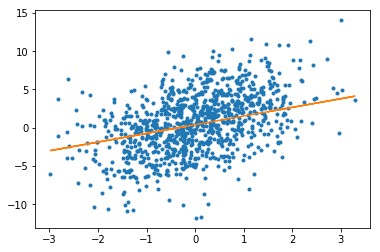

In [44]:
regress_values = linear_regression(X[:,0], Y, 0.01, num_iters, n)

graph_gradient_descent(X[:,0], Y, regress_values[0], regress_values[1])

## Part 3: Theory [total of 50%]

### Question 1

In the SLR model, the probability distribution of $Y$ (i.e., $Y_i$) has the same mean and variance for all levels of $X$ (i.e., $X_i$). True or False? Explain.

([array([  0.,   0.,   0.,   5.,  12.,  24.,  47.,  85., 110., 159., 144.,
         138., 115.,  78.,  55.,  16.,   5.,   6.,   1.,   0.]),
  array([  0.,   0.,   2.,   6.,   7.,  24.,  55.,  79., 131., 136., 169.,
         139., 110.,  76.,  44.,  12.,   7.,   3.,   0.,   0.]),
  array([  1.,   0.,   3.,   2.,  15.,  29.,  43.,  92.,  97., 125., 138.,
         158., 122.,  94.,  36.,  29.,   9.,   5.,   1.,   1.]),
  array([  0.,   1.,   0.,   3.,   9.,  30.,  43.,  78., 115., 151., 171.,
         141., 126.,  67.,  41.,  13.,   8.,   3.,   0.,   0.]),
  array([  0.,   1.,   0.,   7.,  14.,  28.,  49.,  58., 123., 150., 178.,
         132., 114.,  67.,  43.,  24.,   7.,   4.,   0.,   1.]),
  array([  1.,   0.,   0.,   7.,   8.,  25.,  45.,  85., 116., 124., 175.,
         150.,  96.,  92.,  38.,  24.,   9.,   5.,   0.,   0.]),
  array([  0.,   1.,   0.,   6.,  10.,  21.,  41.,  76., 122., 162., 177.,
         133., 116.,  74.,  35.,  23.,   1.,   2.,   0.,   0.]),
  array([  0.,   2.,

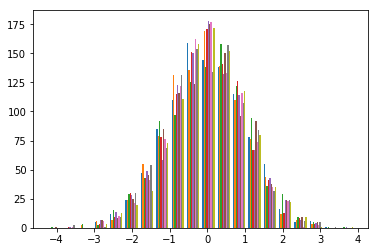

### Question 2

The number of points above the fitted regression line is always equal to the number of points below it. True or False? Explain.

### Question 3

In a SLR model, what does $\beta_1$ measure?  
A: <br>
Slope of the regression. In other words, the mean increase in the dependent variable, Y, per unit increase in the independent variable, X.

### Question 4

In the context of an SLR model, prove the following:

- $E[Y_i] = \beta_0 + \beta_1 X_i$ 
- $V(Y_i) = \sigma^2 \hspace{5pt} \forall \hspace{5pt} i$ 

\begin{align}
Var(X) = E[(X - E[X])^2]

\end{align}


### Question 5

For the SLR model, $Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$, how many random variables are there. Explain.

### Question 6

Write out the normal error regression model and its assumptions (in English and math).

### Question 7

What does a negative value of $\beta_1$ indicate about the relation between $X$ and $Y$?

$$ b_0 = \frac{1}{n} \Big( \sum Y_i - b_1 \sum X_i \Big) $$
$$ b_1 = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sum (X_i - \bar{X})^2}$$

### Question 8

Are hypotheses tested concerning the actual values of the coefficients, e.g., $\beta_1$, or their estimated values, e.g., $b_1$? Why?

### Question 9

You compute a coefficient of determination for a regression model an obtain an $R^2=0.832$. What does the strength of the coefficient of determination say about the causal relationship between the explanatory and response variables?

### Question 10

You compute a coefficient of determination for a regression model, regressing crime rate per capita ($Y$) on the size of municipal police force ($X$), obtaining an $R^2 = 0.6533$. What can you say about the relationship between $Y$ and $X$?

### Question 11

From the discussion of SLR so far, how do you believe outliers will effect the regression line? 

### Question 12

Write out the hypothesis test which tests for the statistical significance of $\beta_1$ for an SLR model. Be sure to include the null an alternate hypothesis, the critical value including degrees of freedom (two-tailed test) for $\alpha = 0.05$ and an interpretation of both possible results. 

### Question 13

Using ```modified_SENIC_data_01.csv```
1. Regress Infection Risk ($Y$) on Length of Stay ($X$). Report the $R^2$, $b_0$ and $b_1$  values.
2. Multiply the observations, both $X$ and $Y$, by 192; we will refer to these as $X_{(2)}$ and $Y_{(2)}$. Regress $Y_{(2)}$ on $X_{(2)}$. Report the $R^2$, $b_0$ and $b_1$  values.
3. Multiply only $Y$ by 47; we will refer to this as $Y_{(3)}$. Regress $Y_{(3)}$ on $X$. Report the $R^2$, $b_0$ and $b_1$  values.
4. Multiply only $X$ by 12; we will refer to this as $X_{(3)}$. Regress $Y$ on $X_{(3)}$. Report the $R^2$, $b_0$ and $b_1$  values.


**Succinctly** explain what you have gleaned from this exercise. Include a summarized tabular representation of the regression output and the associated $R^2$, $b_0$ and $b_1$ values.

### Question 14

Using the ```fourDataSets.csv```, regress $Y$ on $X$ for $i=1,2,3,4$, i.e., generate four separate SLR models. **For each** of the four data sets, run and report summary statistics, generate a scatter plot and run a SLR model, reporting the regression function $R^2$, $R_a^2$, and the significance of $b_1$ ($p$-value). Intelligently discuss what you observe about each data set and the data sets as a whole.